In [1]:
%load_ext autoreload
%autoreload 2

import os
import torch
from transformers import AutoImageProcessor, AutoModelForImageClassification
from tqdm import tqdm 

from torch.utils.data import DataLoader
import datasets


from quantization_tools import *
from wrapper import Wrapper
from evaluation import eval
from utils import prepare_trainable_params, print_file_size
from finetuning import ce_finetune, kd_finetune

: 

In [1]:
!conda list

# packages in environment at /home/msst/miniconda3/envs/rapids_env:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   2.1.0                    pypi_0    pypi
aiohappyeyeballs          2.4.3              pyhd8ed1ab_0    conda-forge
aiohttp                   3.11.8          py312h178313f_0    conda-forge
aiosignal                 1.3.1              pyhd8ed1ab_0    conda-forge
anyio                     4.6.2.post1        pyhd8ed1ab_0    conda-forge
aom                       3.9.1                hac33072_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0          py312h66e93f0_5    conda-forge
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens                 2.4.1                    pypi_0    pypi
a

In [2]:
#model_path = 'microsoft/resnet-18'
model_path = '/home/msst/repo/local/cv/pretrained_models/resnet-18'
path_to_save_models = '/home/msst/repo/Quantization/weights/seminar'

device = 'cuda'

In [3]:
# path_to_dataset = '/home/msst/repo/local/cv/datasets/ImageNet'
# image_processor = AutoImageProcessor.from_pretrained(model_path)

# train_dataset = datasets.load_dataset(
#     path_to_dataset, 
#     split="train"
# )

# test_dataset = datasets.load_dataset(
#     path_to_dataset, 
#     split="test"
# )

# def preprocess(sample):
#     if sample['image'].mode != 'RGB':
#         sample['image'] = sample['image'].convert('RGB')

#     sample['image'] = image_processor(sample['image'], return_tensors="pt")['pixel_values'][0]
#     return sample

# train_dataset = train_dataset.map(preprocess)
# test_dataset = test_dataset.map(preprocess)

# train_dataset.set_format(type='torch', columns=['image', 'label'])
# test_dataset.set_format(type='torch', columns=['image', 'label'])

# path_to_processed_dataset = '/home/msst/repo/local/cv/datasets/ImageNet/processed_data'
# test_dataset.save_to_disk(os.path.join(path_to_processed_dataset, 'test'))
# train_dataset.save_to_disk(os.path.join(path_to_processed_dataset, 'train'))

In [3]:
path_to_processed_dataset = '/home/msst/repo/local/cv/datasets/ImageNet/processed_data'
test_dataset = datasets.load_from_disk(os.path.join(path_to_processed_dataset, 'test'))
train_dataset = datasets.load_from_disk(os.path.join(path_to_processed_dataset, 'train'))

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Loading dataset from disk:   0%|          | 0/62 [00:00<?, ?it/s]

### FP32

In [7]:
# model = AutoModelForImageClassification.from_pretrained(model_path).to(device)
# res = eval(model, test_loader)
# print(res)
# # {'top_1_accuracy': 0.6934, 'top_5_accuracy': 0.8882}

# path_to_save = os.path.join(path_to_save_models, 'resnet_fp32.pth')
# torch.save(model.state_dict(), path_to_save)
# print_file_size(path_to_save)
# # 44.678 Mb

### FP16

In [ ]:
# model = AutoModelForImageClassification.from_pretrained(model_path).to(device)
# with torch.autocast(device_type='cuda'):
#     res = eval(model.half(), test_loader)
# print(res)
# # {'top_1_accuracy': 0.6933, 'top_5_accuracy': 0.888}

# path_to_save = os.path.join(path_to_save_models, 'resnet_fp16.pth')
# torch.save(model.state_dict(), path_to_save)
# print_file_size(path_to_save)
# # 22.363 Mb

Run evaluation...


100%|██████████| 79/79 [00:45<00:00,  1.73it/s]

{'top_1_accuracy': 0.6934, 'top_5_accuracy': 0.888}
22.363 Mb


### INT8

In [28]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)
wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor'))	
}
wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

# res = eval(model, test_loader)
# print(res)
# # {'top_1_accuracy': 0.6906, 'top_5_accuracy': 0.8874}

In [29]:
wrap_rule = {
    QLinear : QuantizedLinear(),
    QConv2d : QuantizedConv2d()
}

wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

path_to_qunatized_model = '/home/msst/repo/Quantization/weights/seminar/lsq_8bit_quantized.pth'
torch.save(model.state_dict(), path_to_qunatized_model)
print_file_size(path_to_qunatized_model)

11.278 Mb


In [30]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)
wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor'))	
}
wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

wrap_rule = {
    QLinear : QuantizedLinear(),
    QConv2d : QuantizedConv2d()
}
wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

res = eval(model, test_loader)
print(res)
model.load_state_dict(torch.load(path_to_qunatized_model, weights_only=True))
res = eval(model, test_loader)
print(res)

Run evaluation...


100%|██████████| 79/79 [00:43<00:00,  1.80it/s]


{'top_1_accuracy': 0.6906, 'top_5_accuracy': 0.8874}
Run evaluation...


  8%|▊         | 6/79 [00:03<00:42,  1.73it/s]


KeyboardInterrupt: 

### INT4

##### naive datafree

In [11]:
# model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

# wrap_rule = {
# 	torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor')),
#     torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=4, use_offset=True, group_type='tensor'))
# }
# exceptions = {
# 	'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor'))
# }

# wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
# wrapper.wrap_model(model)

# res = eval(model, test_loader)
# print(res)
# # {'top_1_accuracy': 0.0043, 'top_5_accuracy': 0.0138}

##### CE finetuning

In [6]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=4, use_offset=True, group_type='tensor'))
}
exceptions = {
    'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='tensor'))
}

wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

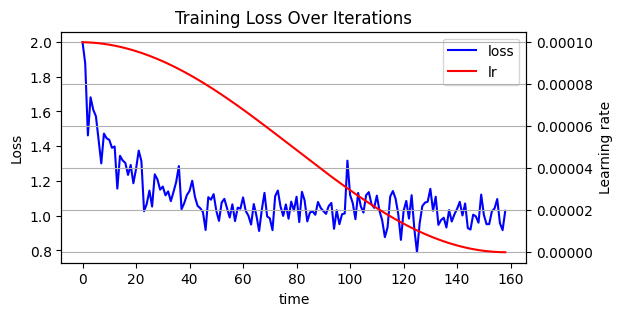

Run evaluation...


100%|██████████| 79/79 [00:47<00:00,  1.65it/s]

{'top_1_accuracy': 0.6738, 'top_5_accuracy': 0.8746}


In [ ]:
train_batch_size = 32
n_epochs = 1
train_lr = 1e-4

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
trainable_parameters = prepare_trainable_params(model, exceptions=['embedder', 'classifier'])
optimizer = torch.optim.Adam(trainable_parameters, lr=train_lr)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10
)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.6563, 'top_5_accuracy': 0.8676} #lr=1e-4 bs=32 small dataset
# {'top_1_accuracy': 0.6738, 'top_5_accuracy': 0.8746} #lr=1e-4 bs=32 large dataset

##### per channel datafree

In [ ]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
	torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=4, use_offset=True, group_type='channel'))
}
exceptions = {
	'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}
wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

# res = eval(model, test_loader)
# print(res)
# # {'top_1_accuracy': 0.6162, 'top_5_accuracy': 0.8412}

In [35]:
wrap_rule = {
    QLinear : QuantizedLinear(),
    QConv2d : QuantizedConv2d()
}

wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

path_to_qunatized_model = '/home/msst/repo/Quantization/weights/seminar/lsq_4bit_quantized.pth'
torch.save(model.state_dict(), path_to_qunatized_model)
print_file_size(path_to_qunatized_model)

6.003 Mb


In [37]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)
wrap_rule = {
	torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=4, use_offset=True, group_type='channel'))
}
exceptions = {
	'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}
wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

wrap_rule = {
    QLinear : QuantizedLinear(),
    QConv2d : QuantizedConv2d()
}
wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

#res = eval(model, test_loader)
#print(res)
model.load_state_dict(torch.load(path_to_qunatized_model, weights_only=True))
res = eval(model, test_loader)
print(res)

Run evaluation...


100%|██████████| 79/79 [00:43<00:00,  1.80it/s]

{'top_1_accuracy': 0.616, 'top_5_accuracy': 0.841}


##### per channel with CE finetuning

In [8]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=4, use_offset=True, group_type='channel'))
}
exceptions = {
    'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}

wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

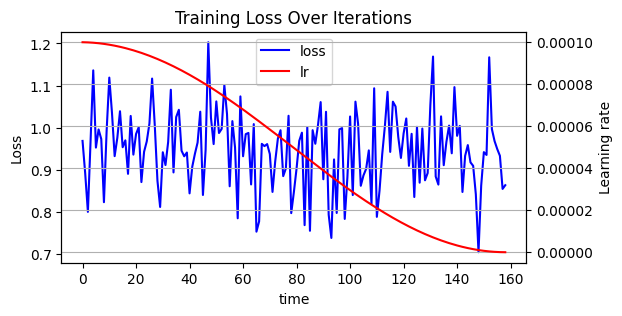

Run evaluation...


100%|██████████| 79/79 [00:48<00:00,  1.62it/s]

{'top_1_accuracy': 0.6874, 'top_5_accuracy': 0.8849}


In [9]:
train_batch_size = 32
n_epochs = 1
train_lr = 1e-4

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
trainable_parameters = prepare_trainable_params(model, exceptions=['embedder', 'classifier'])
optimizer = torch.optim.Adam(trainable_parameters, lr=train_lr)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10
)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.6867, 'top_5_accuracy': 0.8842} #lr=1e-4 bs=32 small dataset
# {'top_1_accuracy': 0.6874, 'top_5_accuracy': 0.8849} #lr=1e-4 bs=32 large dataset

### INT3

##### data free

In [18]:
# model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

# wrap_rule = {
# 	torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
#     torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=3, use_offset=True, group_type='channel'))
# }
# exceptions = {
# 	'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
# }

# wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
# wrapper.wrap_model(model)

# res = eval(model, test_loader)
# print(res)
# # {'top_1_accuracy': 0.0012, 'top_5_accuracy': 0.0063}

##### CE finetuning

In [19]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=3, use_offset=True, group_type='channel'))
}
exceptions = {
    'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}

wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

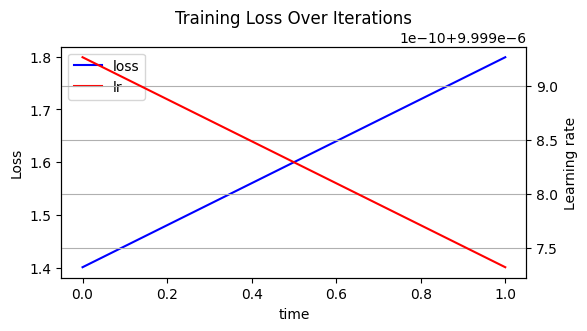

  1%|          | 22/3188 [00:02<06:35,  8.01it/s]


KeyboardInterrupt: 

In [20]:
train_batch_size = 16
n_epochs = 2
train_lr = 1e-5

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
trainable_parameters = prepare_trainable_params(model, exceptions=['embedder', 'classifier'])
optimizer = torch.optim.Adam(trainable_parameters, lr=train_lr)

ce_finetune(
        model, 
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10
)

res = eval(model, test_loader)
print(res)
# {'top_1_accuracy': 0.6299, 'top_5_accuracy': 0.8524} lr=1e-4 bs=32 small dataset
# {'top_1_accuracy': 0.6503, 'top_5_accuracy': 0.8634} lr=1e-4 bs=32 large dataset
# {'top_1_accuracy': 0.6579, 'top_5_accuracy': 0.8660} lr=1e-4 bs=16 large dataset
# {'top_1_accuracy': 0.6613, 'top_5_accuracy': 0.8689} lr=1e-5 bs=16 large dataset


##### KD finetune

In [48]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=3, use_offset=True, group_type='channel'))
}
exceptions = {
    'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}

wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

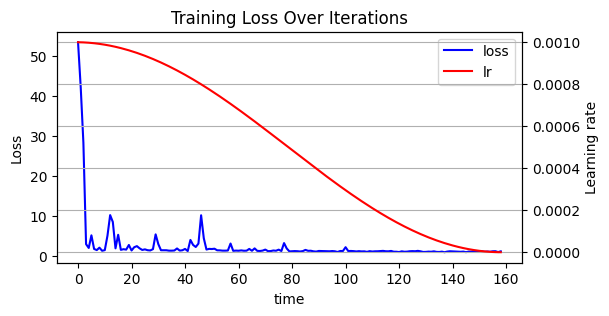

Run evaluation...


100%|██████████| 79/79 [00:49<00:00,  1.60it/s]

{'top_1_accuracy': 0.6636, 'top_5_accuracy': 0.8705}


In [ ]:
train_batch_size = 32
n_epochs = 1
train_lr = 1e-3
 
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
trainable_parameters = prepare_trainable_params(model, exceptions=['embedder', 'classifier'])
optimizer = torch.optim.Adam(trainable_parameters, lr=train_lr)
teacher_model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

kd_finetune(
        model, 
        teacher_model,
        optimizer, 
        train_loader, 
        n_epochs=n_epochs,
        use_scheduler=True,
        time_step=10,
        T=2,
        ce_loss_weight=0.75
)

res = eval(model, test_loader)
print(res)

# {'top_1_accuracy': 0.6644, 'top_5_accuracy': 0.8713} lr=1e-4 bs=16 large dataset
# {'top_1_accuracy': 0.6668, 'top_5_accuracy': 0.8735} lr=2e-4 bs=16 large dataset
# {'top_1_accuracy': 0.6686, 'top_5_accuracy': 0.8714} lr=3e-4 bs=16 large dataset

In [51]:
#torch.save(model.state_dict(), '/home/msst/repo/Quantization/weights/seminar/lsq_3bit.pth')

### Use Quantized Model 

In [92]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=3, use_offset=True, group_type='channel'))
}
exceptions = {
    'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}

wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

In [93]:
path_to_model = '/home/msst/repo/Quantization/weights/seminar/lsq_3bit.pth'
print_file_size(path_to_model)
model.load_state_dict(torch.load(path_to_model, weights_only=True))

44.740 Mb


<All keys matched successfully>

In [94]:
# res = eval(model, test_loader)
# print(res)

In [95]:
wrap_rule = {
    QLinear : QuantizedLinear(),
    QConv2d : QuantizedConv2d()
}

wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

In [96]:
# res = eval(model, test_loader)
# print(res)

In [97]:
path_to_qunatized_model = '/home/msst/repo/Quantization/weights/seminar/lsq_3bit_quantized.pth'
torch.save(model.state_dict(), path_to_qunatized_model)
print_file_size(path_to_qunatized_model)

4.673 Mb


In [99]:
model.load_state_dict(torch.load(path_to_qunatized_model, weights_only=True))

<All keys matched successfully>

In [100]:
res = eval(model, test_loader)
print(res)

Run evaluation...


100%|██████████| 79/79 [00:48<00:00,  1.61it/s]

{'top_1_accuracy': 0.6636, 'top_5_accuracy': 0.8705}


### TEST

In [5]:
model = AutoModelForImageClassification.from_pretrained(model_path).to(device)

wrap_rule = {
    torch.nn.Linear : QLinear(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel')),
    torch.nn.Conv2d : QConv2d(weight_quantizer=Quantizer(bit_width=3, use_offset=True, group_type='channel'))
}
exceptions = {
    'resnet.embedder.embedder.convolution': QConv2d(weight_quantizer=Quantizer(bit_width=8, use_offset=True, group_type='channel'))
}

wrapper = Wrapper(wrap_rule=wrap_rule, exceptions=exceptions)
wrapper.wrap_model(model)

wrap_rule = {
    QLinear : QuantizedLinear(),
    QConv2d : QuantizedConv2d()
}

wrapper = Wrapper(wrap_rule=wrap_rule)
wrapper.wrap_model(model)

In [6]:
res = eval(model, test_loader)
print(res)

Run evaluation...


 16%|█▋        | 13/79 [00:08<00:42,  1.55it/s]


KeyboardInterrupt: 

In [9]:
path_to_qunatized_model = '/home/msst/repo/Quantization/weights/seminar/lsq_3bit_quantized.pth'
print_file_size(path_to_qunatized_model)
model.load_state_dict(torch.load(path_to_qunatized_model, weights_only=True))

0.178 Mb


<All keys matched successfully>

In [8]:
res = eval(model, test_loader)
print(res)

Run evaluation...


100%|██████████| 79/79 [00:44<00:00,  1.77it/s]

{'top_1_accuracy': 0.0018, 'top_5_accuracy': 0.006}


In [14]:
stare_dict = torch.load(path_to_qunatized_model, weights_only=True)
for key in stare_dict:
    print(key)

resnet.embedder.embedder.convolution.step
resnet.embedder.embedder.convolution.offset
resnet.embedder.embedder.normalization.weight
resnet.embedder.embedder.normalization.bias
resnet.embedder.embedder.normalization.running_mean
resnet.embedder.embedder.normalization.running_var
resnet.embedder.embedder.normalization.num_batches_tracked
resnet.encoder.stages.0.layers.0.layer.0.convolution.step
resnet.encoder.stages.0.layers.0.layer.0.convolution.offset
resnet.encoder.stages.0.layers.0.layer.0.normalization.weight
resnet.encoder.stages.0.layers.0.layer.0.normalization.bias
resnet.encoder.stages.0.layers.0.layer.0.normalization.running_mean
resnet.encoder.stages.0.layers.0.layer.0.normalization.running_var
resnet.encoder.stages.0.layers.0.layer.0.normalization.num_batches_tracked
resnet.encoder.stages.0.layers.0.layer.1.convolution.step
resnet.encoder.stages.0.layers.0.layer.1.convolution.offset
resnet.encoder.stages.0.layers.0.layer.1.normalization.weight
resnet.encoder.stages.0.layers.0

In [157]:
import torch

# Example tensor
tensor = torch.randint(-4, 4, (3, 3), dtype=torch.int8)  # Random tensor with values in range [-4, 3]
print(tensor)

tensor([[ 0,  1, -2],
        [-4, -1,  1],
        [ 3,  1, -4]], dtype=torch.int8)


In [158]:
class Compressor:
	def __init__(self, bit_width):
		self.bit_width = bit_width
    
	def compress_to_int8_tensor()

In [159]:
import math

def pad_string_to_bytes(string):
    while len(string) % 8 != 0:
        string = '0' + string
    return string


def unpad_string_from_bytes(string, tensor_shape, bit_width):
    n_elems = math.prod(tensor_shape)
    return string[-n_elems*bit_width:]


def tensor_to_string(tensor, bit_width):
    tensor_shape = list(tensor.shape)
    array = tensor.flatten().to(torch.int32)
    neg_clip = 2**(bit_width-1)
    array+=neg_clip
    
    string = ''
    for value in array:
        string+=format(value, '03b')
    
    return pad_string_to_bytes(string), tensor_shape

In [160]:
bit_width=3

string, tensor_shape = tensor_to_string(tensor, bit_width=bit_width)
len(string)

32

In [169]:
def string_to_int8_tensor(string):
    tensor = []
    for i in range(0, len(string), 8):
        byte = int(string[i:i+8], 2) - 128
        tensor.append(byte)
    return torch.tensor(tensor, dtype=torch.int8)

int8_tensor = string_to_int8_tensor(string)
print(int8_tensor)

tensor([-124,   40,  -69,  104], dtype=torch.int8)


In [171]:
def int8_tensor_to_string(int8_tensor):
    """Преобразует torch.tensor типа int8 в строку из нулей и единиц."""
    if int8_tensor.dtype != torch.int8:
        raise ValueError("Тензор должен быть типа int8.")
    
    binary_string = ''
    for byte in int8_tensor:
        # Преобразуем значение в диапазоне -128 до 127 в диапазон 0 до 255
        unsigned_byte = byte.item() + 128
        # Преобразуем в двоичное представление с ведущими нулями
        binary_string += format(unsigned_byte, '08b')
    
    return binary_string

string = int8_tensor_to_string(int8_tensor)

In [172]:
def string_to_tensor(string, tensor_shape, bit_width):
    string = unpad_string_from_bytes(string, tensor_shape, bit_width=bit_width)
    array = []
    n_elems = math.prod(tensor_shape)
    for start_idx in range(0, n_elems * bit_width, bit_width):
        array.append(int(string[start_idx:start_idx+bit_width], 2))
    array = torch.tensor(array, dtype=torch.int16)
    
    neg_clip = 2**(bit_width-1)
    array -= neg_clip
    tensor = array.reshape(tensor_shape)
    return tensor.to(torch.int8)

string_to_tensor(string, tensor_shape, bit_width)

tensor([[ 0,  1, -2],
        [-4, -1,  1],
        [ 3,  1, -4]], dtype=torch.int8)

In [173]:
tensor

tensor([[ 0,  1, -2],
        [-4, -1,  1],
        [ 3,  1, -4]], dtype=torch.int8)

In [44]:
def string_to_bytes(binary_string):
    """Преобразует строку из нулей и единиц в байты."""
    # Убедимся, что длина строки кратна 8
    while len(binary_string) % 8 != 0:
        binary_string = '0' + binary_string  # Дополняем слева нулями

    byte_array = bytearray()
    for i in range(0, len(binary_string), 8):
        byte = int(binary_string[i:i+8], 2)  # Преобразуем 8 бит в целое число
        byte_array.append(byte)
    
    return byte_array

def save_to_binary_file(filename, binary_string):
    """Сохраняет строку из нулей и единиц в бинарный файл."""
    byte_data = string_to_bytes(binary_string)
    with open(filename, 'wb') as f:
        f.write(byte_data)

def read_from_binary_file(filename):
    """Читает бинарный файл и преобразует его содержимое обратно в строку из нулей и единиц."""
    binary_string = ''
    with open(filename, 'rb') as f:
        byte = f.read(1)
        while byte:
            binary_string += format(byte[0], '08b')  # Преобразуем байт в строку из 8 бит
            byte = f.read(1)
    return binary_string

# Пример использования
binary_string = '010100010101110011010'  # Пример строки
filename = 'binary_data.bin'

# Сохранение в файл
save_to_binary_file(filename, binary_string)

# Чтение из файла
loaded_string = read_from_binary_file(filename)
print("Загруженная строка:", loaded_string)

Загруженная строка: 000010100010101110011010
